# PROJECT: Investigate a No-Show Appointments Dataset

## Table of Contents
<ul>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#projections">Projections</a></li>
</ul>

<a id='introduction'></a>
## Introduction

In this notebook, we will be exploring a database obtained from Kaggle, with information from over 100 thousand medical appointment records in Brazil. The database contains different patient records related to the appointment details for location and time, relevant information about the patients' health status and an approximation of their socio-economical characteristics based on welfare enrollment.

The variety of data provided could give us insight as to why some people do not attend their appointments. Some preliminary questions before checking the descriptive data could make us wonder a few things: 
- Which are more likely to attend their appointments: men or women? 
- How does age factor in appointment attendance? 
- Are patients enrolled in welfare programs more likely to attend?
- Do patients with higher disease burden attend their appointments more?
- Does the SMS notification help improve attendance?

We will use NumPy, Pandas and Matplotlib to analyze this database. We will also import datetime to get some days calculations.

In [453]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

First, we will load and explore the data to find any apparent inconsistencies or anything that needs cleaning up. We will start by looking at the first rows before loading.

In [454]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Then, we will look at data types for each variable and will check for total number of rows and if there is any null values.

In [455]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


This data set has 14 different columns and 110526 rows of observations. It also looks like it doesn't have null values. Some useful variables have data types that could be improved, like `ScheduledDay` and `AppointmentDay`, which should be converted to datatime if we wanted to use those variables. The `PatiendId` variable is a float type with very long numbers, which should probably be changed if we wanted to look at patients with multiple appointments. We could also summarize the burden disease for each patient to explore that variable as a whole instead of looking at each condition. Before those changes, we should check if there are any duplicates.

In [456]:
df.duplicated().sum()

0

To use the `PatientId variable`, we will convert the data type to a string so we can see the full number and be able to identify recurrent or unique patients. For this, we convert the `PatientId column` to `str` type, and then we remove the last two characters for better visualization of each ID.

**Note: I started doing this but couldn't find a proper way to do the analysis, so I'll keep the code here as an exercise of data wrangling.**

In [457]:
df['PatientId'] = df['PatientId'].astype(str)
df['PatientId'] = df['PatientId'].str.rstrip('.0')

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Next, we change the `ScheduledDay` and `AppointmentDay` types to `datetime`. However, when looking at values for `AppointmentDay`, it does not seem to have the time for appointments. We will check for this, looking at value counts.

In [458]:
df['AppointmentDay'].value_counts()

2016-06-06T00:00:00Z    4692
2016-05-16T00:00:00Z    4613
2016-05-09T00:00:00Z    4520
2016-05-30T00:00:00Z    4514
2016-06-08T00:00:00Z    4479
2016-05-11T00:00:00Z    4474
2016-06-01T00:00:00Z    4464
2016-06-07T00:00:00Z    4416
2016-05-12T00:00:00Z    4394
2016-05-02T00:00:00Z    4376
2016-05-18T00:00:00Z    4373
2016-05-17T00:00:00Z    4372
2016-06-02T00:00:00Z    4310
2016-05-10T00:00:00Z    4308
2016-05-31T00:00:00Z    4279
2016-05-05T00:00:00Z    4273
2016-05-19T00:00:00Z    4270
2016-05-03T00:00:00Z    4256
2016-05-04T00:00:00Z    4168
2016-06-03T00:00:00Z    4090
2016-05-24T00:00:00Z    4009
2016-05-13T00:00:00Z    3987
2016-05-25T00:00:00Z    3909
2016-05-06T00:00:00Z    3879
2016-05-20T00:00:00Z    3828
2016-04-29T00:00:00Z    3235
2016-05-14T00:00:00Z      39
Name: AppointmentDay, dtype: int64

As suspected, we will not be able to take a look at how attendance varies with the time of the day, but we can still look at the distance between both dates. We proceed to change the data type to datetime for both variables.

**Note: I started doing this but couldn't find a proper way to do the analysis, so I'll keep the code here as an exercise of data wrangling.**

In [459]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

df.dtypes

PatientId                      object
AppointmentID                   int64
Gender                         object
ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
Age                             int64
Neighbourhood                  object
Scholarship                     int64
Hipertension                    int64
Diabetes                        int64
Alcoholism                      int64
Handcap                         int64
SMS_received                    int64
No-show                        object
dtype: object

We will add a new column with a total of all basal conditions listed to get a sense of total disease burden for each patient.

In [460]:
df['DiseaseTotal'] = df['Hipertension'] + df['Diabetes'] + df['Alcoholism'] + df['Handcap']
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,DiseaseTotal
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2


Lastly, the `No-show` column is really confusing, so we will rename the column to `Attendance`, and replace the No values to Attended and the Yes values to Did not attend.

In [461]:
df.rename(columns={'No-show': 'Attendance'}, inplace=True)
df['Attendance'].replace('No', 'Attended', inplace=True)
df['Attendance'].replace('Yes', 'Did not attend', inplace=True)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Attendance,DiseaseTotal
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,Attended,1
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,Attended,0
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,Attended,0
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,Attended,0
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,Attended,2


<a id='eda'></a>
# Exploratory Data Analysis

After cleaning up our data, and before checking our preliminary questions, we will take a look at the proportion of people not attending their appointments. For this, we will create a pie plot for better visualization.

In [462]:
sizes = df['Attendance'].value_counts() / df['Attendance'].value_counts().sum()

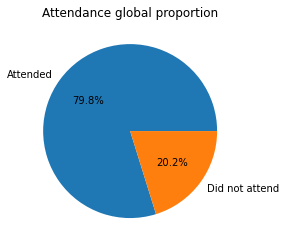

In [463]:
plt.pie(sizes, labels=('Attended', 'Did not attend'), autopct='%1.1f%%')
plt.title('Attendance global proportion');

It seems like there is a higher proportion for people attending their appointments rather than not showing up.
To find the potential reasons for a no-show, we will explore our first preliminary question: 

### Which are more likely to attend their appointments: men or women? 

We will create a plot to see the proportion of attendance for both genders and compare. First, we count the values for `Attendance` for male and female, and get the total for each.

We will create a proportion function first to use for later variables as well.

In [464]:
def proportion(x):
    group = df.query(x)
    counts = group['Attendance'].value_counts()
    total = counts.sum()
    proportion = counts / total
    return proportion

First, we get the proportions from our new function:

In [465]:
menproportion = proportion("Gender=='M'")
femproportion = proportion("Gender=='F'")

Then we start making our plot:

In [491]:
ind = np.arange(len(menproportion))
width = 0.35

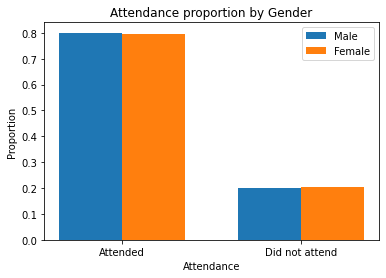

In [492]:
men_bars = plt.bar(ind, menproportion, width, label='Male')
fem_bars = plt.bar(ind + width, femproportion, width, label='Female')
legends = ('Male', 'Female')

plt.ylabel('Proportion')
plt.xlabel('Attendance')
plt.title('Attendance proportion by Gender')
locations = ind + width / 2  # xtick locations
labels = ['Attended', 'Did not attend']  # xtick labels
plt.xticks(locations, labels)
plt.legend(legends);

Apparently, in this sample, the difference of attendance between women and men is not distinguishable. This is probably not the best variable to predict attendance.

### How does age factor in appointment attendance? 

We will take a look at our second question. First, we need to divide our age data into groups to get a better plot. We will look at the value counts first.

In [468]:
df['Age'].value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: Age, Length: 104, dtype: int64

We can see the highest count is for babies younger than one year-old. We can also see there is a '-1' value for age. This could be a typing error, but we can't know for sure, so it's better to remove this row.

In [469]:
df = df[df['Age'] != -1]
df['Age'].value_counts()

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: Age, Length: 103, dtype: int64

Now, we can divide our patients into age groups. We will use a simple division, based on potential dependance of someone else to attend the appointments: Child (0-12), Teen (13-17), Adult (17-65), Senior (+65). We will be using our previously defined function to get the proportions:

In [470]:
childproportion = proportion("Age < 13")
teenproportion = proportion("Age >= 13 and Age < 18")
adultproportion = proportion("Age >= 18 and Age < 65")
seniorproportion = proportion("Age >= 65")

In [471]:
ind = np.arange(len(childproportion))
width = 0.2

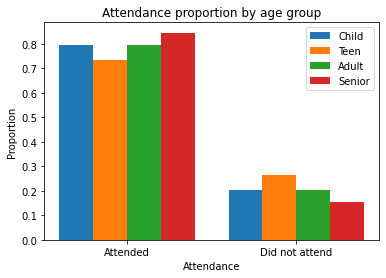

In [472]:
minor_bars = plt.bar(ind, childproportion, width, label='Child')
teen_bars = plt.bar(ind + width, teenproportion, width, label='Adult')
adult_bars = plt.bar(ind + width*2, adultproportion, width, label='Adult')
senior_bars = plt.bar(ind + width*3, seniorproportion, width, label='Senior')
legends = ('Child', 'Teen', 'Adult', 'Senior')

plt.ylabel('Proportion')
plt.xlabel('Attendance')
plt.title('Attendance proportion by age group')
locations = ind + width*6 / 4  # xtick locations
labels = ['Attended', 'Did not attend']  # xtick labels
plt.xticks(locations, labels)
plt.legend(legends);

We can see some difference between age groups: First, the teen group seems to miss their appointments the most. On the other hand, seniors have the highest attendance proportion among all groups. This is expected considering their health requires greater medical supervision.

Our next question was:
### Are patients enrolled in welfare programs more likely to attend?

Let's use the same function as before to get proportions:

In [473]:
onwproportion = proportion("Scholarship==1")
notwproportion = proportion("Scholarship==0")

In [474]:
ind = np.arange(len(onwproportion))
width = 0.4

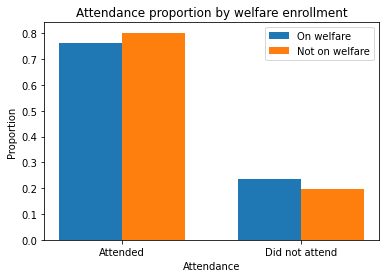

In [493]:
onw_bars = plt.bar(ind, onwproportion, width, label='On welfare')
notw_bars = plt.bar(ind + width, notwproportion, width, label='Not on welfare')
legends = ('On welfare', 'Not on welfare')

plt.ylabel('Proportion')
plt.xlabel('Attendance')
plt.title('Attendance proportion by welfare enrollment')
locations = ind + width / 2  # xtick locations
labels = ['Attended', 'Did not attend']  # xtick labels
plt.xticks(locations, labels)
plt.legend(legends);

Surprisingly, we can see attendance is higher for patients without welfare enrollment for this dataset. This difference could be due to the fact that patients without welfare attend medical consultation with more autonomy than those on welfare.

Let's look at each group's size. For this, we can use a function if we need to check later for other variables.

In [494]:
def total(x):
    group = df.query(x)
    counts = group['Attendance'].value_counts()
    total = counts.sum()
    return total

Let's look at the total for each group.

In [495]:
total("Scholarship==1")

10861

In [478]:
total("Scholarship==0")

99665

The amount of patients without welfare is almost 10 times higher than those on welfare. This could also explain the difference among groups.

Let's explore our next question:
### Do patients with higher disease burden attend their appointments more?

To answer this, we created a new column named `DiseaseTotal` for basal conditions registered for each patient and now we will be doing the same process as before to look at the difference in attendance based on how many conditions the patient has. 

In [479]:
zeroproportion = proportion('DiseaseTotal == 0')
oneproportion = proportion('DiseaseTotal == 1')
twoproportion = proportion('DiseaseTotal == 2')
threeproportion = proportion('DiseaseTotal == 3')
fourproportion = proportion('DiseaseTotal == 4')

In [480]:
ind = np.arange(len(zeroproportion))
width = 0.18

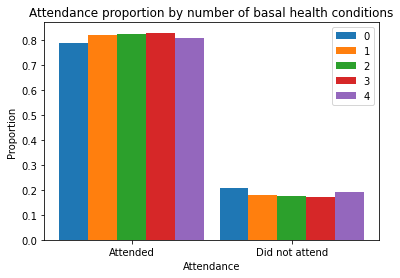

In [481]:
zero_bars = plt.bar(ind, zeroproportion, width, label='0')
one_bars = plt.bar(ind + width, oneproportion, width, label='1')
two_bars = plt.bar(ind + width*2, twoproportion, width, label='2')
three_bars = plt.bar(ind + width*3, threeproportion, width, label='3')
four_bars = plt.bar(ind + width*4, fourproportion, width, label='4')
legends = ('0', '1', '2', '3', '4')

plt.ylabel('Proportion')
plt.xlabel('Attendance')
plt.title('Attendance proportion by number of basal health conditions')
locations = ind + width*10 / 5  # xtick locations
labels = ['Attended', 'Did not attend']  # xtick labels
plt.xticks(locations, labels)
plt.legend(legends);

Surprisingly, the ones who miss their appointments the most are the ones with either zero basal conditions or with all four basal conditions listed.

To get a better look at these results, we could check how the sample size differs among groups.

In [482]:
zerototal = total('DiseaseTotal == 0')
zerototal

84114

In [483]:
onetotal = total('DiseaseTotal == 1')
onetotal

18014

In [484]:
fourtotal = total('DiseaseTotal == 4')
fourtotal

63

Clearly, the size difference among groups is quite big, so we need to consider that when looking at the proportions. If the sample sizes for each group were closer in size, we could make better conclusions.

For our last question:

### Does the SMS notification help improve attendance?

We will be doing the same process as before.

In [485]:
smsproportion = proportion('SMS_received==1')
nosmsproportion = proportion('SMS_received==0')

In [486]:
ind = np.arange(len(smsproportion))
width = 0.4

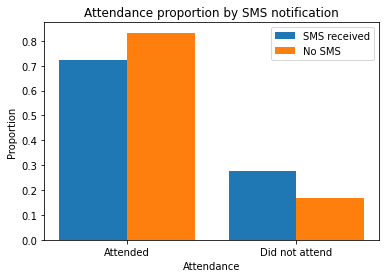

In [487]:
sms_bars = plt.bar(ind, smsproportion, width, label='SMS received')
nosms_bars = plt.bar(ind + width, nosmsproportion, width, label='No SMS')
legends = ('SMS received', 'No SMS')

plt.ylabel('Proportion')
plt.xlabel('Attendance')
plt.title('Attendance proportion by SMS notification')
locations = ind + width / 2  # xtick locations
labels = ['Attended', 'Did not attend']  # xtick labels
plt.xticks(locations, labels)
plt.legend(legends);

Unexpectedly, we see that patients who received an SMS notification missed their appointments more than the ones who didn't receive a notification. Once again, let's look at group size to see what's happening.

In [488]:
smstotal = total('SMS_received==1')
smstotal

35482

In [489]:
nosmstotal = total('SMS_received==0')
nosmstotal

75044

When looking at the data like this, we realize the amount of patients without an SMS notification is much bigger than that received one, so this could also be skewing the results.

<a id='conclusions'></a>
## Conclusions

In this notebook, we analyzed a dataset and used descriptive statistics to try and give ideas of factors that could help predict if a patient will show up to their appointments (with the necessary tools).

From the preliminary questions, we got certain tentative answers:
- Gender doesn't seem to affect the attendance greatly.
- The youngest and oldest group attend their appointments more.
- Patients without welfare attend their appointments more than patients on welfare.
- Patients with zero and patients with all listed basal health conditions miss their appointments more frequently.
- SMS notification relates negatively with patient attendance.

These are all conclusions drawn from descriptive analysis, and inferential analysis would be needed to make more accurate conclusions.

<a id='projections'></a>
## Projections
These are things I would like to learn in the future. I tried to answer the following questions, but could move on because I couldn't find a way to filter the data properly or to convert it to something useful:

- **How does attendance vary between one-time patients and recurring patients?** Couldn't figure out how to label each patient based on how many times they showed up in the database.
- **How does the waiting length between the scheduled day and appointment day affect the attendance?** Couldn't convert the data properly to only get the delta in days.